# Explanation of the larger context around this notebook

See the [slides](https://github.com/Josh-Joseph/tsc-2019/tree/master/doc/TSC%202019) from [TSC 2019](https://www.tsc2019-interlaken.ch/)

# Notebook setup

In [1]:
# import the used packages/modules and call the needed jupyter notebook line magics 

import sys
sys.path.append('../src')
import time
import numpy as np
from IPython.display import clear_output
import world
from simple_agents import DoNothingAgent, RandomAgent
from training import load_pretrained_agent
from brain_utils import get_brain_state, visualize_weights, visualize_activations

%matplotlib inline

# The environment and the agent's "physical" form

## Intuition for the environment

[OpenAI's LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)
- The agent is a lunar lander attempting to softly land between the flags
- Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points
- Each leg ground contact is +10
- Firing the engines is a small negative reward
- Small positive reward for smoother flight
- Fuel is infinite
- Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine

In [2]:
%%HTML
<video width="480" height="360" controls>
  <source src="videos/openai_lunarlander_video.mp4" type="video/mp4">
</video>

## Intuition for agents in the environment

In [3]:
# An agent that does nothing
    
agent = DoNothingAgent()
episode_history = world.run_episode(agent, seed=2)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved -119 total reward


In [4]:
# An agent that takes random actions

agent = RandomAgent()
episode_history = world.run_episode(agent, seed=2)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved -89 total reward


# Our agent

The structure of the agent:
![The structure of the agent](images/agent_structure.png)

## Semantically important regions for the agent

In [5]:
def I_am_high_above_the_ground(observation):
    return observation[1] > 0.5

def I_am_low_to_the_ground(observation):
    return observation[1] <= 0.5

def I_am_to_the_left_of_the_center(observation):
    return observation[0] > 0.

def I_am_to_the_right_of_the_center(observation):
    return observation[0] <= 0.

def I_am_falling_too_fast(observation):
    return observation[3] < -0.2

regions = [
    I_am_high_above_the_ground, 
    I_am_low_to_the_ground, 
    I_am_to_the_left_of_the_center, 
    I_am_to_the_right_of_the_center,
    I_am_falling_too_fast
]

In [6]:
def print_matching_regions(observation):
    for region in regions:
        print('{}: {}'.format(region.__name__, region(episode_history['observation'][episode_index][:8])))

I_am_high_above_the_ground: True
I_am_low_to_the_ground: False
I_am_to_the_left_of_the_center: False
I_am_to_the_right_of_the_center: True
I_am_falling_too_fast: True


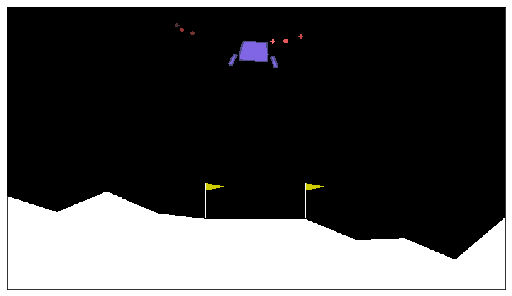

In [7]:
episode_index = 50

world.visualize(episode_history['world_image'][episode_index])

print_matching_regions(episode_history['observation'][episode_index])

## Conversion of recurrent_activations to internal state

In [8]:
def recurrent_activations_to_internal_state(recurrent_activations):
    
    internal_state = set()
    
    for activation, region in zip(recurrent_activations, regions):
        if activation > 0.5:
            internal_state.add(region.__name__)
            
    return internal_state

## Training the agent

In [9]:
agent = load_pretrained_agent()

print(agent.qnetwork_local)

InternalQNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=69, out_features=128, bias=True)
  (fc3): Linear(in_features=192, out_features=5, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)


The performance of the agent during training:
![The training performance of the agent](images/training_performance.png)

## The agent acting in the environment

In [10]:
episode_history = world.run_episode(agent, seed=2)
print("The agent recieved {} total reward".format(int(round(sum(episode_history['reward'])))))

The agent recieved 72 total reward


# Brain state and internal state instances of the agent

In [11]:
def visualize_brain_state_and_internal_state_instance(episode_index):

    brain_state = get_brain_state(agent, episode_history['observation'][episode_index])
    
    recurrent_activations = brain_state['activations'][3]
    internal_state = recurrent_activations_to_internal_state(recurrent_activations)
    
    visualize_activations(brain_state)
    visualize_weights(brain_state)
    
    world.visualize(episode_history['world_image'][episode_index])
    
    print("Internal state: \n{}".format(internal_state))

Internal state: 
{'I_am_low_to_the_ground', 'I_am_to_the_left_of_the_center'}


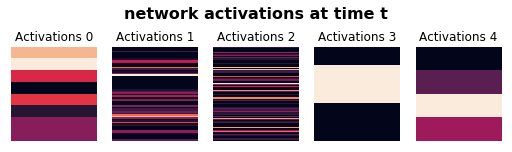

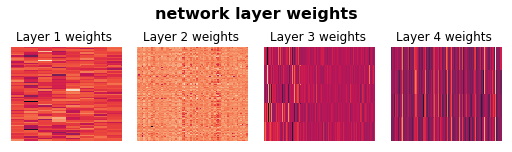

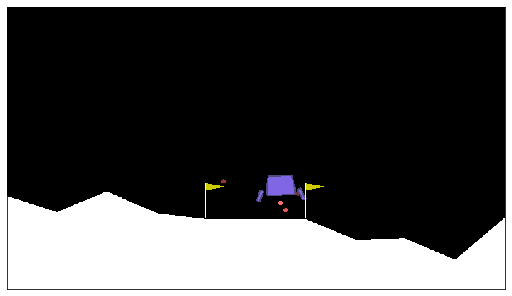

In [ ]:
import matplotlib.pyplot as plt

for episode_i in range(0, len(episode_history['observation']), 25):
    clear_output(wait=True)
    visualize_brain_state_and_internal_state_instance(episode_i)
    plt.show()
    time.sleep(3)